In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from epam.sequences import translate_sequences

We're going to be interested in the frequency of multinucleotide mutations, which is the number of mutations per codon, even if this isn't a coding sequence.

In [2]:
def count_multi_mutations(indicator_vector):
    "Counts the number of mutations that are in a codon with at least 2 mutations."
    # Trim the vector so its length is a multiple of 3
    n = len(indicator_vector)
    n_codons = n // 3
    trimmed_vector = indicator_vector[:n_codons * 3]
    
    # Reshape the vector into a 2D array where each row represents a codon
    codon_matrix = trimmed_vector.reshape(-1, 3)
    
    # Sum along axis 1 to count the number of mutations in each codon
    codon_sums = np.sum(codon_matrix, axis=1)
    
    return np.sum(codon_sums * (codon_sums >= 2))
    
print(count_multi_mutations(np.array([0, 1, 0,  1, 1, 0,  0, 0, 0,  1, 1, 1,  0, 1]).astype(bool)))
print(count_multi_mutations(np.array([0, 1, 0,  1, 1, 0,  0, 0, 0,  1, 0, 1,  0, 1]).astype(bool)))

5
4


In [3]:
def mutation_vector_of(parent, child):
    parent_array = np.array(list(parent))
    child_array = np.array(list(child))
    
    # Check for 'N' in either parent or child
    n_mask = (parent_array == 'N') | (child_array == 'N')
    
    # Compare each position
    mutations = parent_array != child_array
    
    # If 'N' is in either string, set to False
    mutations[n_mask] = False
    
    return mutations


def mutation_column_of(col1, col2):
    return [mutation_vector_of(p, c) for p, c in zip(col1, col2)]

def process_sequences(pcp_df):
    pcp_df.drop(pcp_df.columns[0], axis=1, inplace=True)
    pcp_df["nt_mutations"] = mutation_column_of(pcp_df["parent"], pcp_df["child"])
    pcp_df["nt_mutation_count"] = [np.sum(x) for x in pcp_df["nt_mutations"]]
    pcp_df["parent_length"] = [len(x) for x in pcp_df["parent"]]
    pcp_df["multi_mutation_count"] = pcp_df["nt_mutations"].apply(count_multi_mutations)
    pcp_df["multi_mutation_frac"] = pcp_df["multi_mutation_count"] / pcp_df["nt_mutation_count"]

In [4]:
ooframe_df = pd.read_csv("/Users/matsen/re/epam/_ignore/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv")
inframe_df = pd.read_csv("/Users/matsen/re/epam/_ignore/wyatt-10x-1p5m_pcp_2023-10-07.csv")

# # delete the first base of every parent sequence in ooframe_df
# ooframe_df["parent"] = [x[1:] for x in ooframe_df["parent"]]
# ooframe_df["child"] = [x[1:] for x in ooframe_df["child"]]

process_sequences(ooframe_df)
process_sequences(inframe_df)

inframe_df

,sample_id,family,parent,child,v_gene,child_is_leaf,nt_mutations,nt_mutation_count,parent_length,multi_mutation_count,multi_mutation_frac
0,0,149198,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,IGHV3-33*01,False,"[False, False, False, False, False, False, Fal...",3,372,0,0.000000
1,0,149198,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,IGHV3-33*01,False,"[False, False, False, False, False, False, Fal...",4,372,0,0.000000
2,0,149198,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,CAAGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,IGHV3-33*01,False,"[False, False, True, False, False, False, Fals...",16,372,2,0.125000
3,0,149198,CAAGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,CAAATGCAGATGGTGGAGTCGGGGGGAGGCGTGGTCCAGCCAGGGA...,IGHV3-33*01,True,"[False, False, False, True, False, False, Fals...",19,372,0,0.000000
4,0,149198,CAAGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,CAAGTGCAACTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,IGHV3-33*01,True,"[False, False, False, False, False, False, Fal...",7,372,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
94624,0,17934,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHV4-39*01,False,"[False, False, False, False, False, False, Fal...",2,357,0,0.000000
94625,0,17934,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTTGTGAAGCCTTCGG...,IGHV4-39*01,True,"[False, False, False, False, False, False, Fal...",8,357,0,0.000000
94626,0,17934,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHV4-39*01,True,"[False, False, False, False, False, False, Fal...",0,357,0,NaN
94627,0,269306,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,IGHV3-23*01,True,"[False, False, False, False, False, False, Fal...",3,348,0,0.000000


In [5]:
ooframe_df.iloc[0].to_dict()

{'sample_id': 316188,
 'family': 1810,
 'parent': 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCGCTGTCTCTGGTTATTCCATCAGCAGTGGTTACTTCTGGGCCTGGATCCGGCAGCCCCCAGGGAAGGGACTGGAGTGGATTGGGAGTATCTCTCATAGTGGGAGCAGCTACTCCAAGTCGTCCCTCAAGAGTCGAGTCATCATCTCAGTAGACACGTCCAACAACCACTTCTCCCTGAAGTTGACCTCTGTGACCGCCGCAGACACGGCCACATATTACTGTGCGAGAGACGGGTAATTATGACGGTTCATTTGAGTACTGGGGCCAGGGAATCCGAGTCGCCGTCTCCTCA',
 'child': 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCGCTGTCTCTGGTTATTCCATCAGCAGTGGTTACTTCTGGGCCTGGATCCGGCAGCCCCCAGGGAAGGGACTGGAGTGGATTGGGAGTATCTCTCATAGTGGGAGCAGCTACTCCAAGTCGTCCCTCAAGAGTCGAGTCATCATCTCAGTAGACACGTCCAACAACCACTTCTCCCTGAAGTTGACCTCTGTGACCGCCGCAGACACGGCCACATATTACTGTGCGAGAGACGGGTAATTATGACGGTTCATTTGAGTACTGGGGCCAGGGAATCCGAGTCGCCGTCTCCTCA',
 'branch_length': 9.965e-07,
 'v_call': 'IGHV4',
 'v_int_start': 65,
 'v_int_end': 293,
 'v_start_pos': 65,
 'v_diff': 0,
 'nt_mutations': array([False, False, False, False, False, False, False, False, False,
       

In [6]:
ooframe_df["nt_mutation_count"].value_counts()

nt_mutation_count
0      35306
1      20575
2       7969
3       4532
4       3230
       ...  
97         1
57         1
89         1
101        1
56         1
Name: count, Length: 67, dtype: int64

In [7]:
inframe_df["nt_mutation_count"].value_counts()

nt_mutation_count
0     34336
1      9002
2      6794
3      5456
4      4455
      ...  
57        1
64        1
56        1
74        1
75        1
Name: count, Length: 66, dtype: int64

In [8]:
ooframe_df["multi_mutation_count"]

0        0
1        0
2        0
3        0
4        0
        ..
84317    0
84318    0
84319    0
84320    0
84321    0
Name: multi_mutation_count, Length: 84322, dtype: int64

In [9]:
ooframe_df["multi_mutation_count"].value_counts()

multi_mutation_count
0     74619
2      5556
4      1537
6       639
3       550
5       358
8       280
7       203
10      123
9       111
11       62
12       60
13       38
16       30
14       29
15       18
18       17
17       16
19       14
22        9
27        3
68        3
23        3
20        3
84        2
86        2
78        2
49        2
26        2
67        2
53        2
58        1
76        1
28        1
37        1
46        1
52        1
97        1
47        1
56        1
89        1
61        1
33        1
34        1
25        1
29        1
35        1
43        1
74        1
82        1
62        1
81        1
93        1
55        1
88        1
50        1
48        1
45        1
Name: count, dtype: int64

In [10]:
inframe_df["multi_mutation_count"].value_counts()

multi_mutation_count
0     72177
2     11572
4      4458
6      2102
8       955
3       641
5       536
10      482
7       384
9       280
12      226
11      165
14      139
13      110
16       79
15       75
17       56
18       49
19       35
20       22
22       21
21       17
24       13
23        8
25        8
27        4
29        3
28        3
31        2
35        2
26        2
32        1
30        1
41        1
Name: count, dtype: int64

<Axes: >

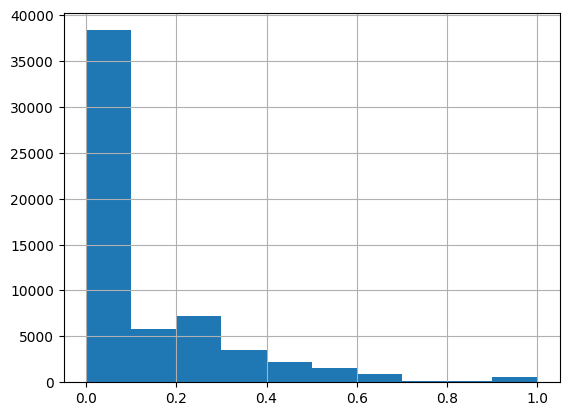

In [11]:
inframe_df["multi_mutation_frac"].hist()

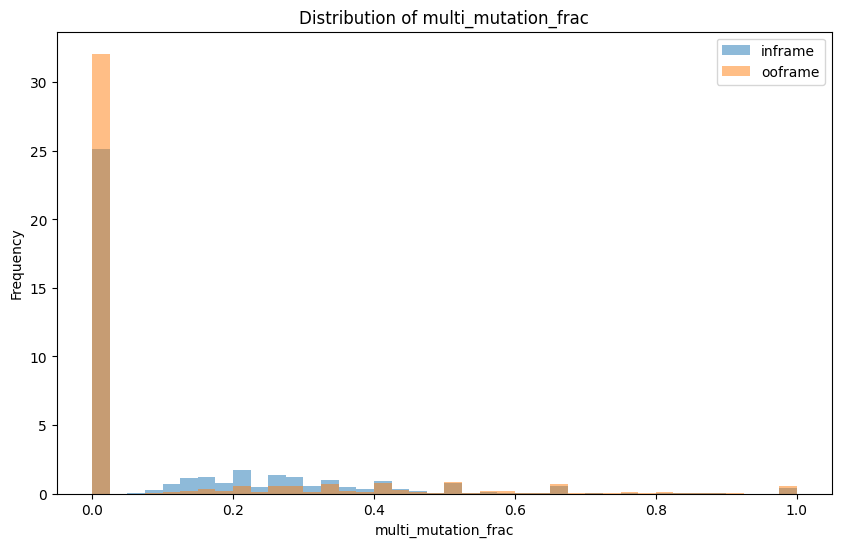

In [12]:
plt.figure(figsize=(10, 6))

plt.hist(inframe_df['multi_mutation_frac'], density=True, alpha=0.5, label='inframe', bins=40)
plt.hist(ooframe_df['multi_mutation_frac'], density=True, alpha=0.5, label='ooframe', bins=40)

plt.title('Distribution of multi_mutation_frac')
plt.xlabel('multi_mutation_frac')
plt.ylabel('Frequency')
plt.legend()

plt.show()


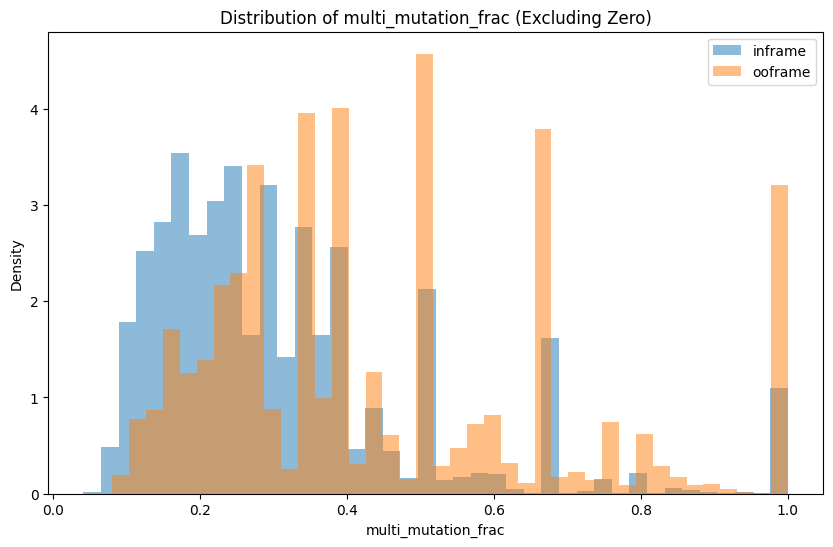

In [13]:
plt.figure(figsize=(10, 6))

# Filter out zero values
inframe_filtered = inframe_df['multi_mutation_frac'][inframe_df['multi_mutation_frac'] > 0]
ooframe_filtered = ooframe_df['multi_mutation_frac'][ooframe_df['multi_mutation_frac'] > 0]

plt.hist(inframe_filtered, density=True, alpha=0.5, label='inframe', bins=40)
plt.hist(ooframe_filtered, density=True, alpha=0.5, label='ooframe', bins=40)

plt.title('Distribution of multi_mutation_frac (Excluding Zero)')
plt.xlabel('multi_mutation_frac')
plt.ylabel('Density')
plt.legend()

plt.show()


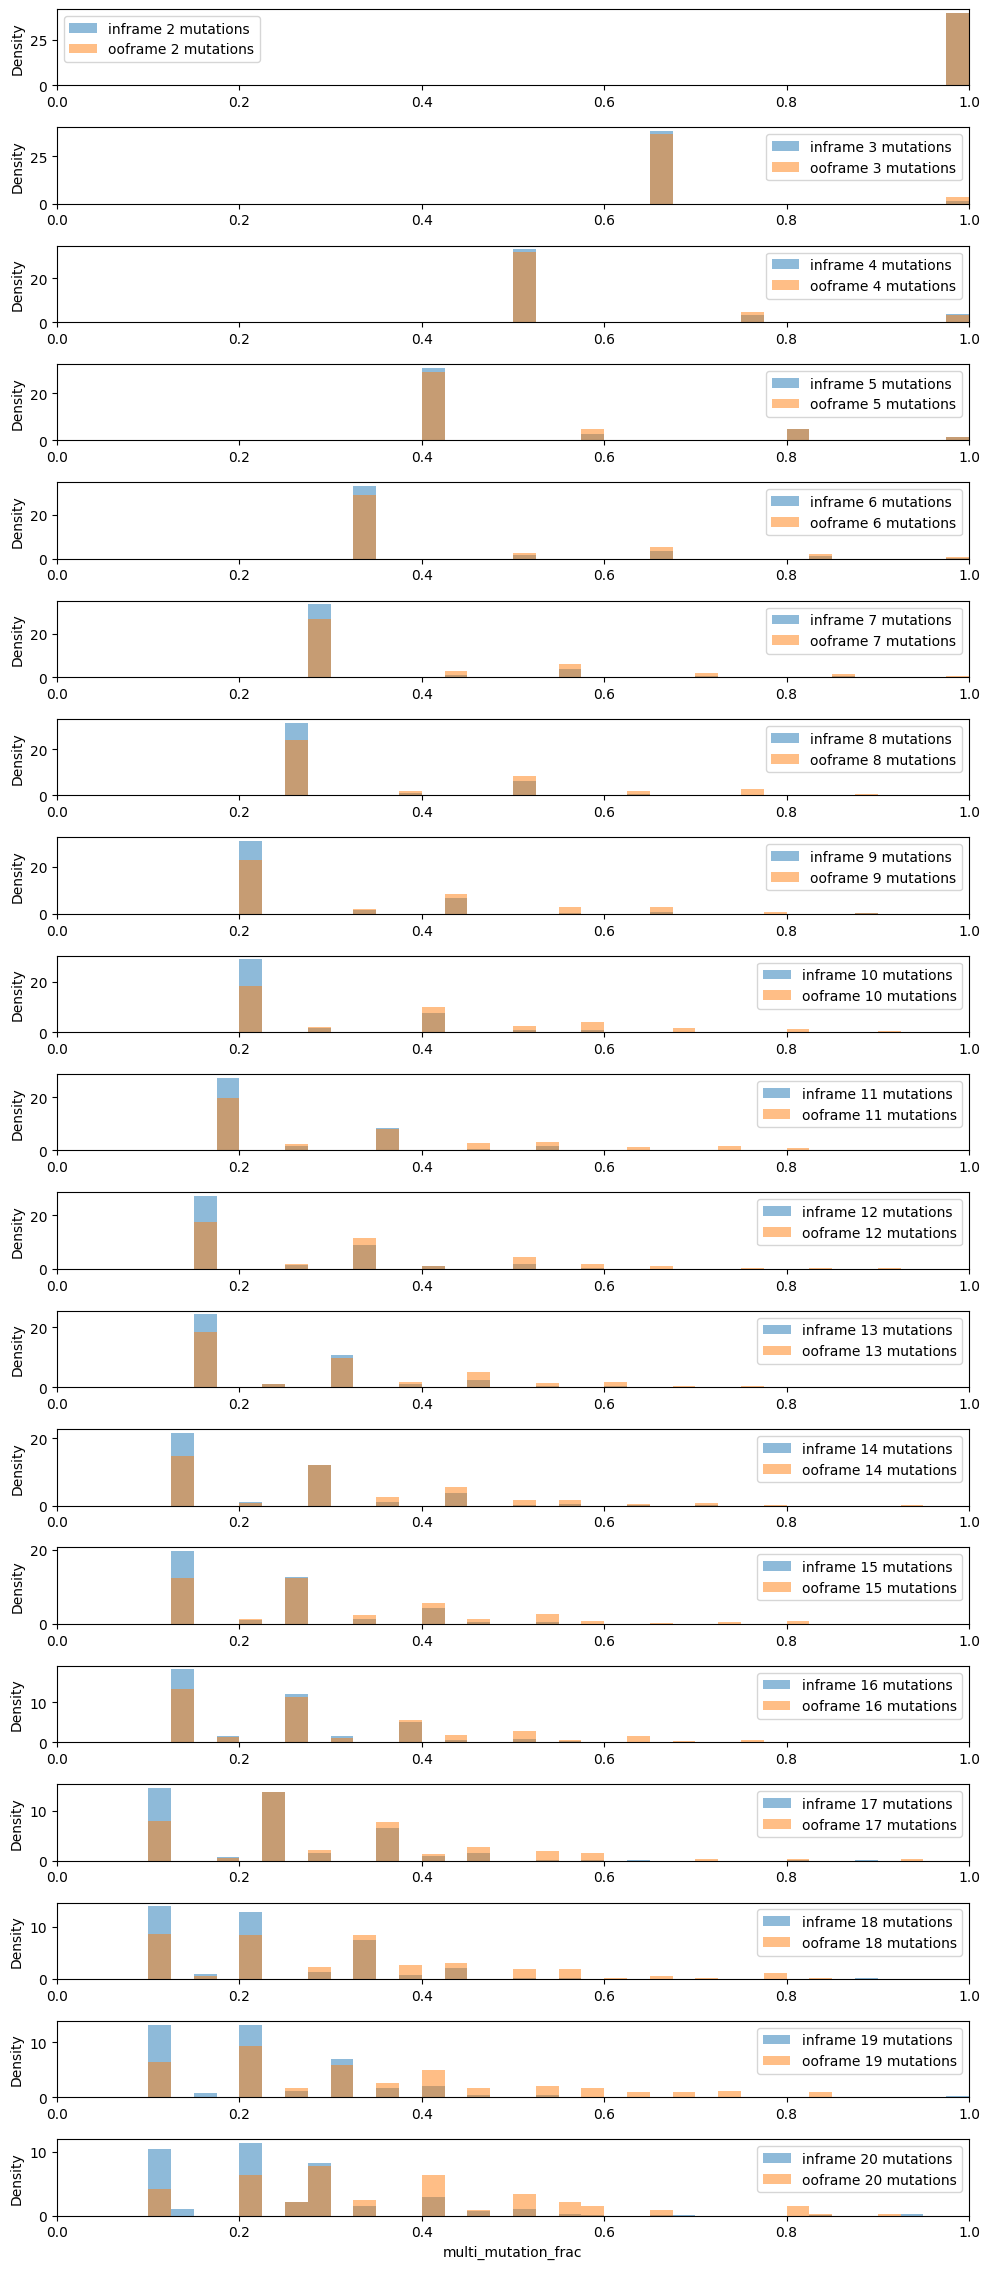

In [14]:
unique_counts = np.arange(2, 21)

# Create a single figure to hold all subplots
fig, axes = plt.subplots(len(unique_counts), 1, figsize=(10, 1.2 * len(unique_counts)))

# Loop through each unique count and plot
for i, count in enumerate(unique_counts):
    ax = axes[i]
    
    inframe_sub = inframe_df[inframe_df['nt_mutation_count'] == count]
    ooframe_sub = ooframe_df[ooframe_df['nt_mutation_count'] == count]
    
    # Filter out zero values
    inframe_filtered = inframe_sub['multi_mutation_frac'][inframe_sub['multi_mutation_frac'] > 0]
    ooframe_filtered = ooframe_sub['multi_mutation_frac'][ooframe_sub['multi_mutation_frac'] > 0]

    if len(inframe_filtered) == 0 and len(ooframe_filtered) == 0:
        continue  # Skip this iteration if both filtered sets are empty
    
    ax.hist(inframe_filtered, density=True, alpha=0.5, label=f'inframe {count} mutations', bins=40, range=(0, 1))
    ax.hist(ooframe_filtered, density=True, alpha=0.5, label=f'ooframe {count} mutations', bins=40, range=(0, 1))
    
    ax.set_xlim(0, 1)  # Set x-axis range from 0 to 1
    ax.set_ylabel('Density')
    ax.legend()

plt.xlabel('multi_mutation_frac')
plt.tight_layout()
plt.show()


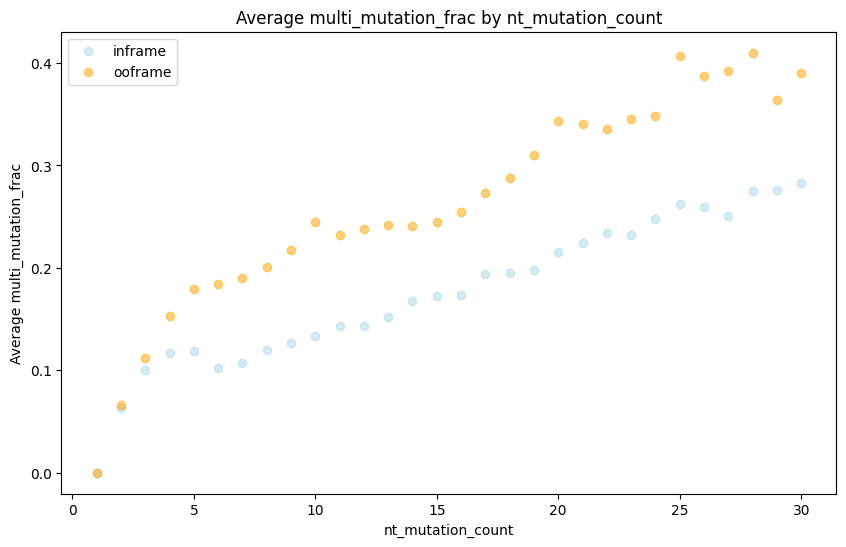

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to compute average multi_mutation_frac
def compute_avg_multi_mutation_frac(df):
    return df.groupby('nt_mutation_count')['multi_mutation_frac'].agg('mean').reset_index()

# Generate average multi_mutation_frac for both datasets
inframe_avg = compute_avg_multi_mutation_frac(inframe_df)
ooframe_avg = compute_avg_multi_mutation_frac(ooframe_df)

# Merge the datasets
merged_avg = pd.merge(inframe_avg, ooframe_avg, on='nt_mutation_count', suffixes=('_inframe', '_ooframe'))
merged_avg = merged_avg[merged_avg['nt_mutation_count'] <= 30]

# Plotting
plt.figure(figsize=(10, 6))

plt.scatter(merged_avg['nt_mutation_count'], merged_avg['multi_mutation_frac_inframe'], 
            label='inframe', color='lightblue', alpha=0.5)

plt.scatter(merged_avg['nt_mutation_count'], merged_avg['multi_mutation_frac_ooframe'], 
            label='ooframe', color='orange', alpha=0.5)

plt.xlabel('nt_mutation_count')
plt.ylabel('Average multi_mutation_frac')
plt.title('Average multi_mutation_frac by nt_mutation_count')
plt.legend()

plt.show()


In [16]:
a_multimut_row = inframe_df[inframe_df['multi_mutation_frac']==0.5].iloc[1]
print(a_multimut_row["parent"])
print(a_multimut_row["child"])
print("".join([str(int(x)) for x in a_multimut_row["nt_mutations"]]))

GAAGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGCAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTTGATGATTATGCCATGCACTGGGTCCGGCAAGCTCCAGGGAAGGGCCTGGAGTGGGTCTCAGGTATTAGTTGGAATAGTGGTAGCATAGGCTATGCGGACTCTGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCCCTGTATCTGCAAATGAACAGTCTGAGAGCTGAGGACACGGCCTTGTATTACTGTGCAAAAGACTCGTCCTACTACTACTACATGGACGTCTGGGGCAAAGGGACCACGGTCACCGTCTCCTCA
GAAGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGCAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTTGATGATTATGCCATGCACTGGGTCCGGCAAGCTCCAGGGAAGGGCCTGGAGTGGGTCTCAGGTATTAGTTGGAATAGTGGTAGCATAGGCTATGCGGACTCTGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCCCTGTATCTGCAAATGAACAGTCTGAGAGCTGAGGACACGGCCTTGTATTACTGTGCAAAAGAGTTGTTATACTACTACTACATGGACGTCTGGGGCAAAGGGACCACGGTCACCGTCTCCTCA
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

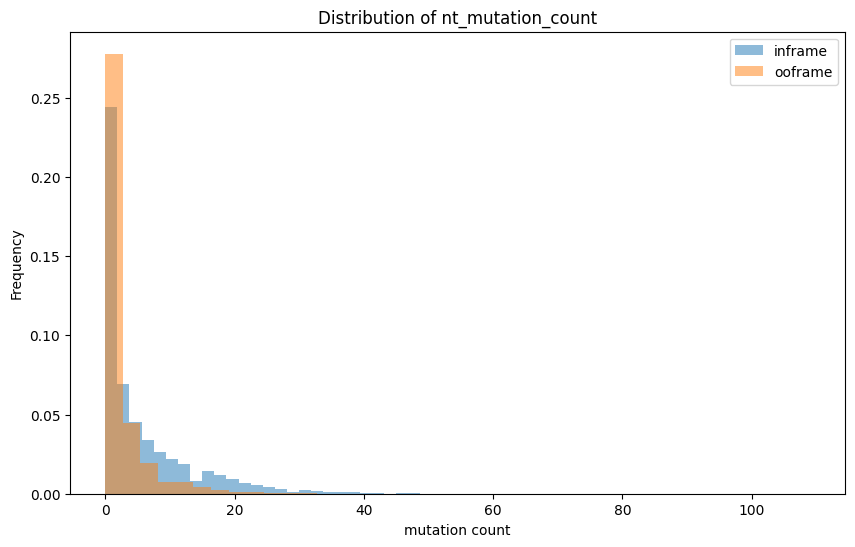

In [17]:
plt.figure(figsize=(10, 6))

plt.hist(inframe_df['nt_mutation_count'], density=True, alpha=0.5, label='inframe', bins=40)
plt.hist(ooframe_df['nt_mutation_count'], density=True, alpha=0.5, label='ooframe', bins=40)

plt.title('Distribution of nt_mutation_count')
plt.xlabel('mutation count')
plt.ylabel('Frequency')
plt.legend()

plt.show()